In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"

In [ ]:
!unzip -q dataset.zip
!unzip -q dataset/dualclass.zip

replace dualclass/files_list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip -q dataset/test2classes.zip

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class Inceptionblock(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool):
        super().__init__()

        # convolution: 1x1 
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        # convolution: 1x1  -> convolution: 3x3 
        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        # convolution: 1x1 -> convolution: 5x5
        # Two 3x3 stacked convolution filters used
        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        # pooling: 3x3 -> convolution: 1x1
        
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool, kernel_size=1),
            nn.BatchNorm2d(pool),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogleNet(nn.Module):

    def __init__(self, num_class=2):
        super().__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        
        self.a3 = Inceptionblock(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inceptionblock(256, 128, 128, 192, 32, 96, 64)

        # The Inception network consists of inception modules stacked upon each other, with occasional max-pooling layers
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inceptionblock(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inceptionblock(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inceptionblock(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inceptionblock(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inceptionblock(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inceptionblock(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inceptionblock(832, 384, 192, 384, 48, 128, 128)

        #input feature size: 8*8*1024
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.prelayer(x)
        x = self.maxpool(x)
        x = self.a3(x)
        x = self.b3(x)

        x = self.maxpool(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.maxpool(x)

        x = self.a5(x)
        x = self.b5(x)

        
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)

        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function

def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('dualclass/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['NORM' 'TUM']


In [ ]:
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['NORM' 'TUM']
7200
7200


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # We use a small batch size here for training
batch_size_test = 100 #
batch_size_val = 100

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('dualclass/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('dualclass/', val_files, val_classes, 
                         transforms=image_transform)
test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: NORM


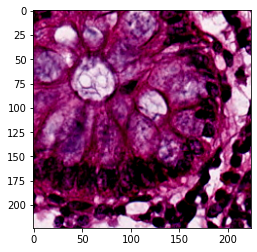

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 30
accuracy_test=[]

for i in range(5):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = GoogleNet().to(device)
  learning_rate = 0.00005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.8)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("GoogleNet2SGD.pth"):
        os.remove("GoogleNet2SGD.pth")
      torch.save(model.state_dict(), 'GoogleNet2SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = GoogleNet(2)
  model.load_state_dict(torch.load('GoogleNet2SGD.pth', map_location=device))
  model=model.to(device)
  
  l,a=test(model, device, test_loader)
  accuracy_test.append(a)
print(accuracy_test)

Experiment:  1
1


<ipython-input-7-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.3983

Test: Average loss: 0.1945, Accuracy: 8521/9096 (93.68%)

2


  0%|          | 0/2123 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f546a84dca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7f546a84dca0>can only test a child process
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train: Average loss: 0.2215



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f546a84dca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f546a84dca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test: Average loss: 0.1633, Accuracy: 8578/9096 (94.31%)

3


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1728

Test: Average loss: 0.1045, Accuracy: 8773/9096 (96.45%)

4


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1559

Test: Average loss: 0.0878, Accuracy: 8834/9096 (97.12%)

5


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1439

Test: Average loss: 0.1239, Accuracy: 8694/9096 (95.58%)

6


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1307

Test: Average loss: 0.1847, Accuracy: 8400/9096 (92.35%)

7


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1212

Test: Average loss: 0.0802, Accuracy: 8834/9096 (97.12%)

8


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1127

Test: Average loss: 0.0605, Accuracy: 8920/9096 (98.07%)

9


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1031

Test: Average loss: 0.1178, Accuracy: 8677/9096 (95.39%)

10


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1049

Test: Average loss: 0.0805, Accuracy: 8846/9096 (97.25%)

11


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0954

Test: Average loss: 0.0529, Accuracy: 8942/9096 (98.31%)

12


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0891

Test: Average loss: 0.0532, Accuracy: 8948/9096 (98.37%)

13


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0838

Test: Average loss: 0.0723, Accuracy: 8872/9096 (97.54%)

14


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0776

Test: Average loss: 0.0529, Accuracy: 8945/9096 (98.34%)

15


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0781

Test: Average loss: 0.0427, Accuracy: 8970/9096 (98.61%)

16


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0751

Test: Average loss: 0.0951, Accuracy: 8777/9096 (96.49%)

17


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0737

Test: Average loss: 0.0608, Accuracy: 8904/9096 (97.89%)

18


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0669

Test: Average loss: 0.0522, Accuracy: 8937/9096 (98.25%)

19


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0652

Test: Average loss: 0.0494, Accuracy: 8937/9096 (98.25%)

20


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0620

Test: Average loss: 0.0533, Accuracy: 8946/9096 (98.35%)

21


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0636

Test: Average loss: 0.0349, Accuracy: 8999/9096 (98.93%)

22


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0630

Test: Average loss: 0.0727, Accuracy: 8889/9096 (97.72%)

23


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0623

Test: Average loss: 0.0358, Accuracy: 8991/9096 (98.85%)

24


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0610

Test: Average loss: 0.0368, Accuracy: 8998/9096 (98.92%)

25


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0509

Test: Average loss: 0.0435, Accuracy: 8989/9096 (98.82%)

26


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0510

Test: Average loss: 0.0551, Accuracy: 8953/9096 (98.43%)

27


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0496

Test: Average loss: 0.1255, Accuracy: 8660/9096 (95.21%)

28


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0490

Test: Average loss: 0.1187, Accuracy: 8669/9096 (95.31%)

29


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0432

Test: Average loss: 0.0362, Accuracy: 8993/9096 (98.87%)

30


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0445

Test: Average loss: 0.0331, Accuracy: 8990/9096 (98.83%)

Test: Average loss: 0.0316, Accuracy: 7138/7200 (99.14%)

Experiment:  2
1


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.4036

Test: Average loss: 0.1871, Accuracy: 8513/9096 (93.59%)

2


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.2180

Test: Average loss: 0.1249, Accuracy: 8724/9096 (95.91%)

3


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1741

Test: Average loss: 0.1280, Accuracy: 8690/9096 (95.54%)

4


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1547

Test: Average loss: 0.0972, Accuracy: 8742/9096 (96.11%)

5


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1416

Test: Average loss: 0.0779, Accuracy: 8842/9096 (97.21%)

6


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1304

Test: Average loss: 0.0745, Accuracy: 8866/9096 (97.47%)

7


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1236

Test: Average loss: 0.0967, Accuracy: 8765/9096 (96.36%)

8


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1104

Test: Average loss: 0.0568, Accuracy: 8917/9096 (98.03%)

9


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1052

Test: Average loss: 0.0801, Accuracy: 8830/9096 (97.08%)

10


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1011

Test: Average loss: 0.0635, Accuracy: 8921/9096 (98.08%)

11


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0904

Test: Average loss: 0.0606, Accuracy: 8937/9096 (98.25%)

12


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0832

Test: Average loss: 0.0526, Accuracy: 8933/9096 (98.21%)

13


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0857

Test: Average loss: 0.0631, Accuracy: 8879/9096 (97.61%)

14


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0807

Test: Average loss: 0.0560, Accuracy: 8939/9096 (98.27%)

15


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0782

Test: Average loss: 0.0462, Accuracy: 8975/9096 (98.67%)

16


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0701

Test: Average loss: 0.0627, Accuracy: 8919/9096 (98.05%)

17


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0671

Test: Average loss: 0.0960, Accuracy: 8802/9096 (96.77%)

18


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0671

Test: Average loss: 0.0386, Accuracy: 8988/9096 (98.81%)

19


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0692

Test: Average loss: 0.0748, Accuracy: 8861/9096 (97.42%)

20


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0646

Test: Average loss: 0.0461, Accuracy: 8985/9096 (98.78%)

21


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0547

Test: Average loss: 0.0481, Accuracy: 8946/9096 (98.35%)

22


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0584

Test: Average loss: 0.0594, Accuracy: 8920/9096 (98.07%)

23


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0512

Test: Average loss: 0.0352, Accuracy: 8997/9096 (98.91%)

24


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0546

Test: Average loss: 0.0720, Accuracy: 8894/9096 (97.78%)

25


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0490

Test: Average loss: 0.3357, Accuracy: 8091/9096 (88.95%)

26


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0508

Test: Average loss: 0.0379, Accuracy: 8995/9096 (98.89%)

27


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0536

Test: Average loss: 0.1189, Accuracy: 8736/9096 (96.04%)

28


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0476

Test: Average loss: 0.0430, Accuracy: 8990/9096 (98.83%)

29


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0493

Test: Average loss: 0.0495, Accuracy: 8959/9096 (98.49%)

30


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0436

Test: Average loss: 0.0537, Accuracy: 8932/9096 (98.20%)

Test: Average loss: 0.0293, Accuracy: 7147/7200 (99.26%)

Experiment:  3
1


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.3784

Test: Average loss: 0.1928, Accuracy: 8451/9096 (92.91%)

2


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.2122

Test: Average loss: 0.1127, Accuracy: 8773/9096 (96.45%)

3


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1743

Test: Average loss: 0.1383, Accuracy: 8613/9096 (94.69%)

4


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1594

Test: Average loss: 0.1518, Accuracy: 8556/9096 (94.06%)

5


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1421

Test: Average loss: 0.0806, Accuracy: 8852/9096 (97.32%)

6


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1350

Test: Average loss: 0.0827, Accuracy: 8857/9096 (97.37%)

7


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1218

Test: Average loss: 0.0742, Accuracy: 8868/9096 (97.49%)

8


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1106

Test: Average loss: 0.0564, Accuracy: 8930/9096 (98.18%)

9


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1020

Test: Average loss: 0.0553, Accuracy: 8924/9096 (98.11%)

10


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0998

Test: Average loss: 0.0805, Accuracy: 8846/9096 (97.25%)

11


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0920

Test: Average loss: 0.0589, Accuracy: 8922/9096 (98.09%)

12


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0920

Test: Average loss: 0.0639, Accuracy: 8894/9096 (97.78%)

13


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0889

Test: Average loss: 0.0512, Accuracy: 8966/9096 (98.57%)

14


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0811

Test: Average loss: 0.0412, Accuracy: 8980/9096 (98.72%)

15


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0791

Test: Average loss: 0.0446, Accuracy: 8958/9096 (98.48%)

16


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0725

Test: Average loss: 0.0981, Accuracy: 8856/9096 (97.36%)

17


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0697

Test: Average loss: 0.0405, Accuracy: 8981/9096 (98.74%)

18


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0651

Test: Average loss: 0.0445, Accuracy: 8968/9096 (98.59%)

19


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0612

Test: Average loss: 0.0503, Accuracy: 8929/9096 (98.16%)

20


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0613

Test: Average loss: 0.0591, Accuracy: 8922/9096 (98.09%)

21


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0610

Test: Average loss: 0.0360, Accuracy: 8990/9096 (98.83%)

22


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0629

Test: Average loss: 0.0470, Accuracy: 8951/9096 (98.41%)

23


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0523

Test: Average loss: 0.0477, Accuracy: 8950/9096 (98.39%)

24


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0551

Test: Average loss: 0.0392, Accuracy: 8985/9096 (98.78%)

25


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0562

Test: Average loss: 0.0489, Accuracy: 8955/9096 (98.45%)

26


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0526

Test: Average loss: 0.0441, Accuracy: 8948/9096 (98.37%)

27


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0468

Test: Average loss: 0.0333, Accuracy: 8996/9096 (98.90%)

28


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0498

Test: Average loss: 0.0364, Accuracy: 8983/9096 (98.76%)

29


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0441

Test: Average loss: 0.0342, Accuracy: 8995/9096 (98.89%)

30


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0463

Test: Average loss: 0.0488, Accuracy: 8944/9096 (98.33%)

Test: Average loss: 0.0273, Accuracy: 7135/7200 (99.10%)

Experiment:  4
1


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.3831

Test: Average loss: 0.1590, Accuracy: 8653/9096 (95.13%)

2


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.2126

Test: Average loss: 0.1282, Accuracy: 8702/9096 (95.67%)

3


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1773

Test: Average loss: 0.0946, Accuracy: 8806/9096 (96.81%)

4


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1538

Test: Average loss: 0.1103, Accuracy: 8742/9096 (96.11%)

5


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1437

Test: Average loss: 0.1370, Accuracy: 8572/9096 (94.24%)

6


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1245

Test: Average loss: 0.0861, Accuracy: 8822/9096 (96.99%)

7


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1212

Test: Average loss: 0.1351, Accuracy: 8585/9096 (94.38%)

8


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1134

Test: Average loss: 0.0700, Accuracy: 8885/9096 (97.68%)

9


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1057

Test: Average loss: 0.0651, Accuracy: 8879/9096 (97.61%)

10


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1012

Test: Average loss: 0.0607, Accuracy: 8914/9096 (98.00%)

11


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0955

Test: Average loss: 0.0742, Accuracy: 8868/9096 (97.49%)

12


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0869

Test: Average loss: 0.1192, Accuracy: 8625/9096 (94.82%)

13


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0883

Test: Average loss: 0.0540, Accuracy: 8923/9096 (98.10%)

14


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0771

Test: Average loss: 0.1538, Accuracy: 8499/9096 (93.44%)

15


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0809

Test: Average loss: 0.0624, Accuracy: 8904/9096 (97.89%)

16


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0740

Test: Average loss: 0.0693, Accuracy: 8915/9096 (98.01%)

17


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0703

Test: Average loss: 0.0692, Accuracy: 8901/9096 (97.86%)

18


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0701

Test: Average loss: 0.0778, Accuracy: 8818/9096 (96.94%)

19


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0728

Test: Average loss: 0.0708, Accuracy: 8851/9096 (97.31%)

20


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0609

Test: Average loss: 0.0645, Accuracy: 8882/9096 (97.65%)

21


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0593

Test: Average loss: 0.1498, Accuracy: 8570/9096 (94.22%)

22


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0582

Test: Average loss: 0.0471, Accuracy: 8953/9096 (98.43%)

23


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0519

Test: Average loss: 0.0544, Accuracy: 8897/9096 (97.81%)

24


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0548

Test: Average loss: 0.0894, Accuracy: 8795/9096 (96.69%)

25


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0532

Test: Average loss: 0.0681, Accuracy: 8885/9096 (97.68%)

26


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0496

Test: Average loss: 0.0374, Accuracy: 8986/9096 (98.79%)

27


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0487

Test: Average loss: 0.0571, Accuracy: 8921/9096 (98.08%)

28


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0477

Test: Average loss: 0.0825, Accuracy: 8810/9096 (96.86%)

29


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0427

Test: Average loss: 0.1182, Accuracy: 8747/9096 (96.16%)

30


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0458

Test: Average loss: 0.0496, Accuracy: 8950/9096 (98.39%)

Test: Average loss: 0.0316, Accuracy: 7138/7200 (99.14%)

Experiment:  5
1


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.3975

Test: Average loss: 0.1951, Accuracy: 8458/9096 (92.99%)

2


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.2186

Test: Average loss: 0.1375, Accuracy: 8657/9096 (95.17%)

3


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1778

Test: Average loss: 0.1246, Accuracy: 8706/9096 (95.71%)

4


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1609

Test: Average loss: 0.0986, Accuracy: 8782/9096 (96.55%)

5


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1431

Test: Average loss: 0.0875, Accuracy: 8820/9096 (96.97%)

6


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1294

Test: Average loss: 0.1699, Accuracy: 8428/9096 (92.66%)

7


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1183

Test: Average loss: 0.0876, Accuracy: 8792/9096 (96.66%)

8


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1182

Test: Average loss: 0.0953, Accuracy: 8783/9096 (96.56%)

9


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0991

Test: Average loss: 0.0707, Accuracy: 8899/9096 (97.83%)

10


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.1072

Test: Average loss: 0.0864, Accuracy: 8804/9096 (96.79%)

11


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0968

Test: Average loss: 0.0578, Accuracy: 8936/9096 (98.24%)

12


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0871

Test: Average loss: 0.0676, Accuracy: 8874/9096 (97.56%)

13


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0877

Test: Average loss: 0.0531, Accuracy: 8935/9096 (98.23%)

14


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0848

Test: Average loss: 0.0511, Accuracy: 8956/9096 (98.46%)

15


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0759

Test: Average loss: 0.0743, Accuracy: 8857/9096 (97.37%)

16


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0732

Test: Average loss: 0.0501, Accuracy: 8949/9096 (98.38%)

17


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0763

Test: Average loss: 0.0544, Accuracy: 8950/9096 (98.39%)

18


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0765

Test: Average loss: 0.0540, Accuracy: 8937/9096 (98.25%)

19


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0698

Test: Average loss: 0.0547, Accuracy: 8926/9096 (98.13%)

20


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0713

Test: Average loss: 0.0455, Accuracy: 8961/9096 (98.52%)

21


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0634

Test: Average loss: 0.0409, Accuracy: 8984/9096 (98.77%)

22


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0617

Test: Average loss: 0.0428, Accuracy: 8953/9096 (98.43%)

23


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0516

Test: Average loss: 0.0365, Accuracy: 8988/9096 (98.81%)

24


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0540

Test: Average loss: 0.0379, Accuracy: 8994/9096 (98.88%)

25


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0532

Test: Average loss: 0.0558, Accuracy: 8948/9096 (98.37%)

26


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0574

Test: Average loss: 0.0602, Accuracy: 8901/9096 (97.86%)

27


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0544

Test: Average loss: 0.0508, Accuracy: 8955/9096 (98.45%)

28


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0483

Test: Average loss: 0.0408, Accuracy: 8973/9096 (98.65%)

29


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0486

Test: Average loss: 0.0478, Accuracy: 8923/9096 (98.10%)

30


  0%|          | 0/2123 [00:00<?, ?it/s]

Train: Average loss: 0.0480

Test: Average loss: 0.0454, Accuracy: 8951/9096 (98.41%)

Test: Average loss: 0.0345, Accuracy: 7133/7200 (99.07%)

[99.13888888888889, 99.26388888888889, 99.09722222222223, 99.13888888888889, 99.06944444444444]


In [1]:
import numpy as np
acc=np.array([99.13888888888889, 99.26388888888889, 99.09722222222223, 99.13888888888889, 99.06944444444444])
print(np.mean(acc))
print(np.std(acc))

99.14166666666668
0.06655082528172583
